<a href="https://colab.research.google.com/github/arihant1805/COVID-Detection/blob/master/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction

### Table contents
 * [import necessary libraries](#import-necessary-libraries)
 * [Data Download](#Data-Download)
 * [Data Preprocessing](#Data-Preprocessing)
 * [LSTM Model](#LSTM-Model)
 * [Model Training](#Model-Training)

## import necessary libraries <a class="anchor" id="import-necessary-libraries"></a>

In [145]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

## Data Download <a class="anchor" id="Data-Download"></a>

In [146]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(wiki_url)
df = table[0]
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [147]:
tickers  = (df[df['GICS Sector'] == 'Information Technology']['Symbol'].tolist()
            + df[df['GICS Sector'] == 'Communication Services']['Symbol'].tolist())
print(f'{len(tickers)} companies which can have dependent stockrpices\n',tickers)

92 companies which can have dependent stockrpices
 ['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK', 'AVGO', 'CDNS', 'CDW', 'CSCO', 'CTSH', 'GLW', 'CRWD', 'DELL', 'ENPH', 'EPAM', 'FFIV', 'FICO', 'FSLR', 'FTNT', 'IT', 'GEN', 'GDDY', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JBL', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NVDA', 'NXPI', 'ON', 'ORCL', 'PLTR', 'PANW', 'PTC', 'QCOM', 'ROP', 'CRM', 'STX', 'NOW', 'SWKS', 'SMCI', 'SNPS', 'TEL', 'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN', 'WDC', 'WDAY', 'ZBRA', 'GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV', 'MTCH', 'META', 'NFLX', 'NWSA', 'NWS', 'OMC', 'PARA', 'TMUS', 'TTWO', 'TKO', 'VZ', 'DIS', 'WBD']


In [148]:
# we will use this much data for now to check the corelation between companies
data = yf.download(tickers, period = '1y')['Close']
data.head()

[*********************100%***********************]  92 of 92 completed


Ticker,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,TRMB,TTWO,TXN,TYL,VRSN,VZ,WBD,WDAY,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-12,175.720276,312.749817,474.089996,189.130814,236.979996,103.470001,206.124237,163.279999,67.805000,334.200012,...,60.540001,147.270004,161.802002,413.359985,185.429993,37.212067,8.34,263.690002,54.467121,289.679993
2024-04-15,171.878403,310.637726,470.100006,187.183136,229.619995,102.220001,203.962433,160.320007,65.800003,328.160004,...,59.410000,145.300003,161.821457,400.679993,183.199997,37.577446,8.36,259.630005,53.235073,283.000000
2024-04-16,168.583984,311.302094,476.220001,188.107788,228.240005,101.330002,207.730713,163.460007,65.690002,326.809998,...,58.919998,145.449997,163.027695,399.220001,182.630005,37.258915,8.14,257.690002,53.711262,280.420013
2024-04-17,167.210464,311.897064,474.450012,186.337173,214.919998,100.339996,198.220795,154.020004,64.817497,325.619995,...,58.490002,143.160004,161.189148,402.839996,181.570007,37.268276,8.23,257.019989,53.038548,276.140015
2024-04-18,166.254944,313.344788,473.179993,184.517395,210.630005,100.730003,192.697296,155.080002,64.297501,324.500000,...,57.860001,140.639999,159.214417,402.950012,182.960007,37.596184,8.31,255.639999,51.640213,273.029999


In [149]:
# the company we are going to focus on is Google
ticker = 'GOOGL' # google's ticker

In [150]:
cor = abs(data.corr()[ticker])
cor

,GOOGL
Ticker,
AAPL,0.482889
ACN,0.356032
ADBE,0.089354
ADI,0.293036
ADSK,0.438195
...,...
VZ,0.330944
WBD,0.426315
WDAY,0.261185


In [151]:
companies = list(cor[cor > 0.56].index)
print('Thes are the 10 company ofcourse other than google and its parent company we are going to focus on\n',
    companies
) # the value 0.56 came from trial

Thes are the 10 company ofcourse other than google and its parent company we are going to focus on
 ['ANET', 'ANSS', 'APH', 'AVGO', 'CDNS', 'CRM', 'CRWD', 'GOOG', 'GOOGL', 'HPE', 'JBL', 'MSFT']


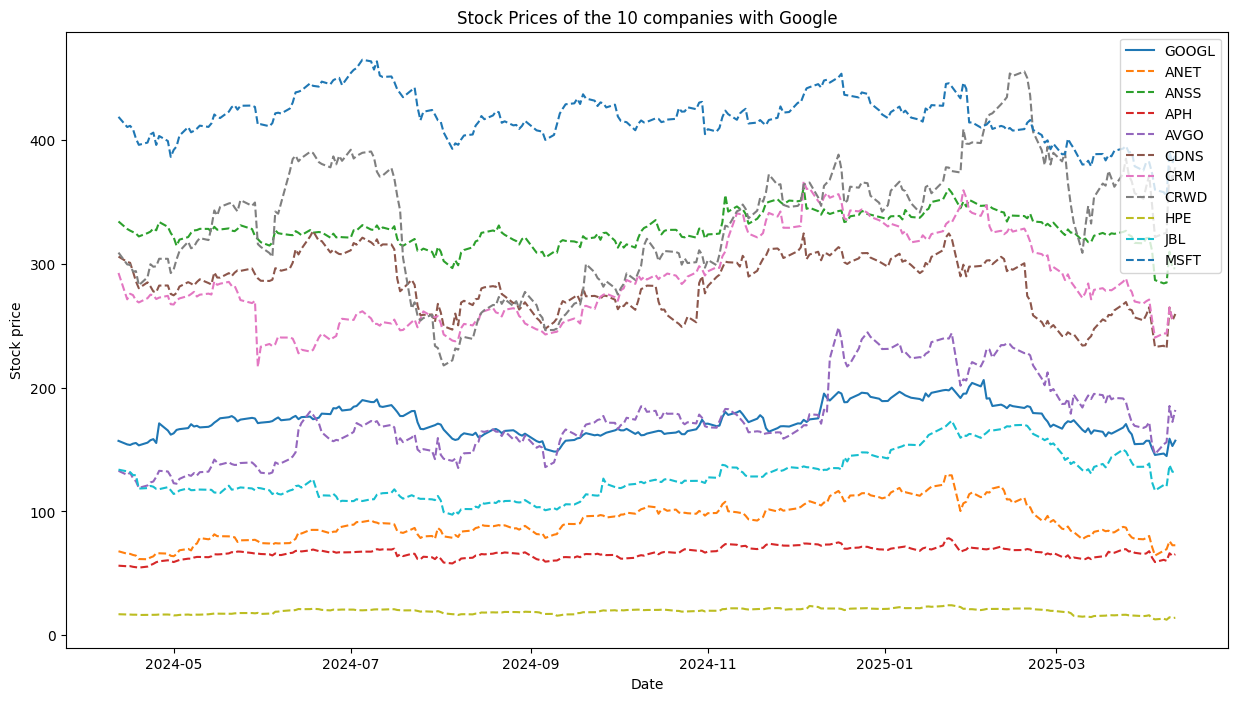

In [152]:
plt.figure(figsize = (15, 8))
plt.title('Stock Prices of the 10 companies with Google')
plt.plot(data.index, data.GOOGL, label = 'GOOGL')
plt.xlabel('Date')
plt.ylabel('Stock price')
for c in companies[:]:
    if c in ['GOOGL', 'GOOG']:
        continue
    plt.plot(data.index, data[c], '--', label = c)
plt.legend();

In [153]:
data = yf.download(companies, period = '10y')['Close'] # we are going to get 5 years for data for model accuracy
data.head()

[*********************100%***********************]  12 of 12 completed


Ticker,ANET,ANSS,APH,AVGO,CDNS,CRM,CRWD,GOOG,GOOGL,HPE,JBL,MSFT
Date,,,,,,,,,,,,
2015-04-13,4.133750,87.529999,13.392879,9.553218,19.07,66.602753,NaN,26.757950,27.301474,NaN,21.656881,36.041931
2015-04-14,4.145000,86.949997,13.374722,9.448812,18.65,66.433975,NaN,26.322216,26.860582,NaN,21.876574,35.947006
2015-04-15,4.236875,87.400002,13.440536,9.595139,18.73,66.731842,NaN,26.428419,26.923281,NaN,21.922333,36.473476
2015-04-16,4.104375,87.779999,13.336133,9.551696,18.60,67.426865,NaN,26.491447,27.046692,NaN,21.592815,36.387180
2015-04-17,4.060625,86.330002,13.154569,9.286479,18.43,65.341789,NaN,26.007574,26.510254,NaN,21.116837,35.921104


In [154]:
# There is no complete data for HPE, CRWD for last 10 yrs
companies.remove('HPE')
companies.remove('CRWD')
data = data.drop(columns = ['HPE', 'CRWD'])
data.head()

Ticker,ANET,ANSS,APH,AVGO,CDNS,CRM,GOOG,GOOGL,JBL,MSFT
Date,,,,,,,,,,
2015-04-13,4.133750,87.529999,13.392879,9.553218,19.07,66.602753,26.757950,27.301474,21.656881,36.041931
2015-04-14,4.145000,86.949997,13.374722,9.448812,18.65,66.433975,26.322216,26.860582,21.876574,35.947006
2015-04-15,4.236875,87.400002,13.440536,9.595139,18.73,66.731842,26.428419,26.923281,21.922333,36.473476
2015-04-16,4.104375,87.779999,13.336133,9.551696,18.60,67.426865,26.491447,27.046692,21.592815,36.387180
2015-04-17,4.060625,86.330002,13.154569,9.286479,18.43,65.341789,26.007574,26.510254,21.116837,35.921104


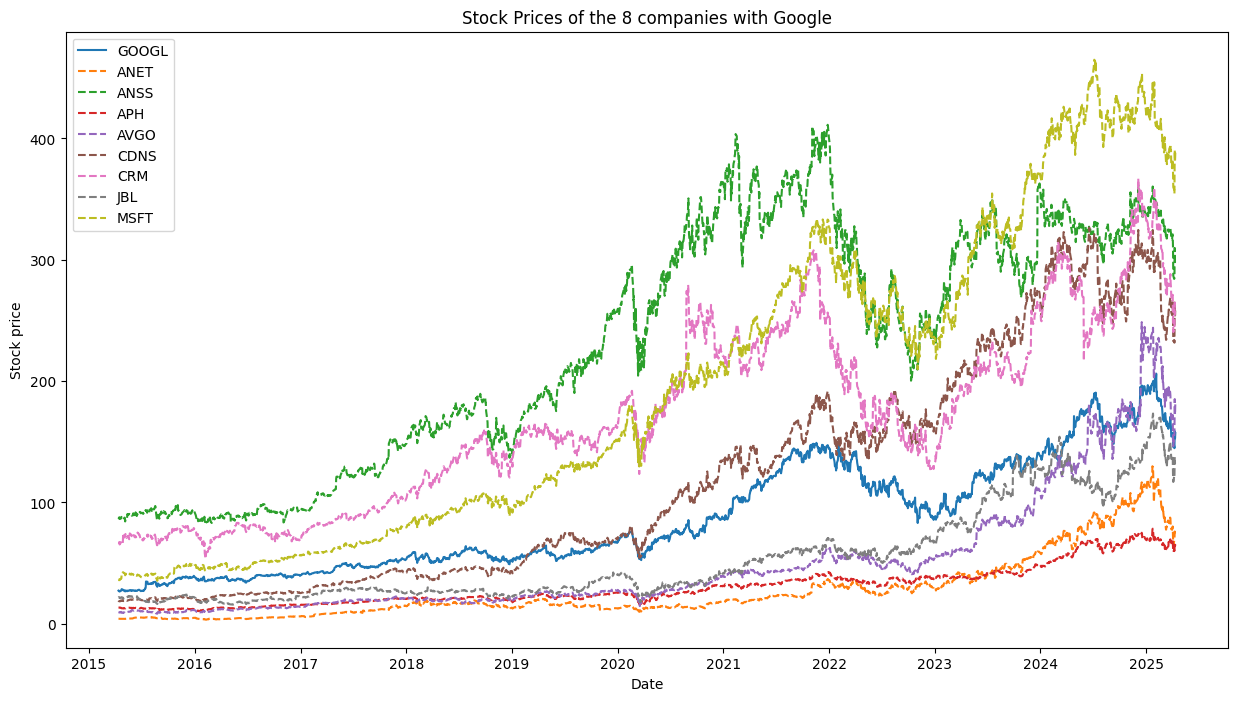

In [155]:
plt.figure(figsize = (15, 8))
plt.title('Stock Prices of the 8 companies with Google')
plt.plot(data.index, data.GOOGL, label = 'GOOGL')
plt.xlabel('Date')
plt.ylabel('Stock price')
for c in companies[:]:
    if c in ['GOOGL', 'GOOG']:
        continue
    plt.plot(data.index, data[c], '--', label = c)
plt.legend();

## Data Preprocessing

In [156]:
data = data.reset_index()
data.drop(columns = ['Date'], inplace = True)
data.head()

Ticker,ANET,ANSS,APH,AVGO,CDNS,CRM,GOOG,GOOGL,JBL,MSFT
0,4.133750,87.529999,13.392879,9.553218,19.07,66.602753,26.757950,27.301474,21.656881,36.041931
1,4.145000,86.949997,13.374722,9.448812,18.65,66.433975,26.322216,26.860582,21.876574,35.947006
2,4.236875,87.400002,13.440536,9.595139,18.73,66.731842,26.428419,26.923281,21.922333,36.473476
3,4.104375,87.779999,13.336133,9.551696,18.60,67.426865,26.491447,27.046692,21.592815,36.387180
4,4.060625,86.330002,13.154569,9.286479,18.43,65.341789,26.007574,26.510254,21.116837,35.921104


In [157]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data[:5]

array([[0.00649171, 0.01703614, 0.04424207, 0.00524395, 0.00207745,
        0.04130564, 0.00571251, 0.00440466, 0.03746538, 0.00152403],
       [0.00658064, 0.01527482, 0.04397492, 0.00480945, 0.00071412,
        0.04076677, 0.00331513, 0.00195025, 0.03886032, 0.001303  ],
       [0.00730688, 0.01664137, 0.04494333, 0.00541841, 0.0009738 ,
        0.04171779, 0.00389945, 0.00229929, 0.03915087, 0.00252887],
       [0.00625951, 0.01779533, 0.0434071 , 0.00523762, 0.00055182,
        0.04393683, 0.00424623, 0.00298631, 0.03705859, 0.00232794],
       [0.00591368, 0.01339205, 0.0407355 , 0.00413387, 0.        ,
        0.03727969, 0.00158398, 0.        , 0.03403634, 0.00124269]])

In [158]:
data = torch.tensor(data)
data[:5]

tensor([[0.0065, 0.0170, 0.0442, 0.0052, 0.0021, 0.0413, 0.0057, 0.0044, 0.0375,
         0.0015],
        [0.0066, 0.0153, 0.0440, 0.0048, 0.0007, 0.0408, 0.0033, 0.0020, 0.0389,
         0.0013],
        [0.0073, 0.0166, 0.0449, 0.0054, 0.0010, 0.0417, 0.0039, 0.0023, 0.0392,
         0.0025],
        [0.0063, 0.0178, 0.0434, 0.0052, 0.0006, 0.0439, 0.0042, 0.0030, 0.0371,
         0.0023],
        [0.0059, 0.0134, 0.0407, 0.0041, 0.0000, 0.0373, 0.0016, 0.0000, 0.0340,
         0.0012]], dtype=torch.float64)

In [159]:
def train_test_split(data, train_size):
    """
    function divides the data in the test train split in the ration of train_size:1-train_size
    data: data you want to divide
    train_size : ratio of train data: whole data
    """

    train_len = int(data.shape[0] * train_size)
    return data[:train_len], data[train_len:]

In [160]:
train_data, test_data = train_test_split(data, 0.8)
train_data.shape, test_data.shape

(torch.Size([2013, 10]), torch.Size([504, 10]))

In [161]:
train_data[:5]

tensor([[0.0065, 0.0170, 0.0442, 0.0052, 0.0021, 0.0413, 0.0057, 0.0044, 0.0375,
         0.0015],
        [0.0066, 0.0153, 0.0440, 0.0048, 0.0007, 0.0408, 0.0033, 0.0020, 0.0389,
         0.0013],
        [0.0073, 0.0166, 0.0449, 0.0054, 0.0010, 0.0417, 0.0039, 0.0023, 0.0392,
         0.0025],
        [0.0063, 0.0178, 0.0434, 0.0052, 0.0006, 0.0439, 0.0042, 0.0030, 0.0371,
         0.0023],
        [0.0059, 0.0134, 0.0407, 0.0041, 0.0000, 0.0373, 0.0016, 0.0000, 0.0340,
         0.0012]], dtype=torch.float64)

In [162]:
class StockPriceDataset(Dataset):
    def __init__ (self, data, context_length):
        self.data = data
        self.context_length = context_length
        self.num_samples = len(data) - context_length

    def __len__ (self):
        return self.num_samples

    def __getitem__ (self, idx):
        x = data[idx: idx + self.context_length]
        y = data[idx + self.context_length, -3]
        return x, y

In [163]:
context_length = 14 * 7 # model will predict stock price using the data of last 14 weaks
batch_size = 64

dataset = StockPriceDataset(train_data, context_length)
val_dataset = StockPriceDataset(test_data, context_length)

train_loader = DataLoader(dataset, batch_size)
val_loader = DataLoader(val_dataset, batch_size)

## LSTM Model

In [193]:
torch.set_default_dtype(torch.float64)
class LSTMModel(nn.Module):
    def __init__(self, num_company):
        super().__init__()

        self.lstm1 = nn.LSTM(
            input_size=num_company,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional= True
            )

        self.lstm2 = nn.LSTM(
            input_size=2 * 128,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
            )

        self.ll = nn.Linear(2 * 128, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        out = self.ll(x)
        return out.squeeze(1)

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_company = len(companies)
model = LSTMModel(num_company)
model.to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(10, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (ll): Linear(in_features=256, out_features=1, bias=True)
)


In [207]:
learning_rate = 1e-3
num_epochs = 50

In [208]:
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

## Model Training

In [209]:
loss_fn = nn.MSELoss()

In [210]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    num_batches = len(train_loader)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / num_batches

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                pred_val = model(X_val)
                loss = criterion(pred_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


In [211]:
train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer)

Epoch [1/50], Train Loss: 0.001093, Val Loss: 0.001072
Epoch [2/50], Train Loss: 0.000865, Val Loss: 0.000174
Epoch [3/50], Train Loss: 0.002504, Val Loss: 0.011018
Epoch [4/50], Train Loss: 0.009387, Val Loss: 0.025186
Epoch [5/50], Train Loss: 0.014457, Val Loss: 0.016883
Epoch [6/50], Train Loss: 0.004922, Val Loss: 0.011127
Epoch [7/50], Train Loss: 0.006303, Val Loss: 0.001156
Epoch [8/50], Train Loss: 0.005909, Val Loss: 0.001068
Epoch [9/50], Train Loss: 0.001252, Val Loss: 0.000077
Epoch [10/50], Train Loss: 0.000599, Val Loss: 0.000677
Epoch [11/50], Train Loss: 0.000629, Val Loss: 0.000256
Epoch [12/50], Train Loss: 0.000507, Val Loss: 0.000120
Epoch [13/50], Train Loss: 0.000461, Val Loss: 0.000144
Epoch [14/50], Train Loss: 0.000425, Val Loss: 0.000258
Epoch [15/50], Train Loss: 0.000448, Val Loss: 0.000423
Epoch [16/50], Train Loss: 0.000516, Val Loss: 0.000472
Epoch [17/50], Train Loss: 0.000484, Val Loss: 0.000244
Epoch [18/50], Train Loss: 0.000395, Val Loss: 0.000044
E

In [212]:
infrence_data = torch.cat(
    tuple(data[i: i + context_length].reshape((1, context_length, 10))
                  for i in range(data.shape[0]-(test_data.shape[0] + context_length + 1), data.shape[0] - context_length - 1)),
    0
    )
with torch.no_grad():
    model.eval()
    infrence_data = infrence_data.to(device)
    pred = model(infrence_data)

pred[:5]

tensor([0.4873, 0.4835, 0.4787, 0.4752, 0.4874], device='cuda:0')

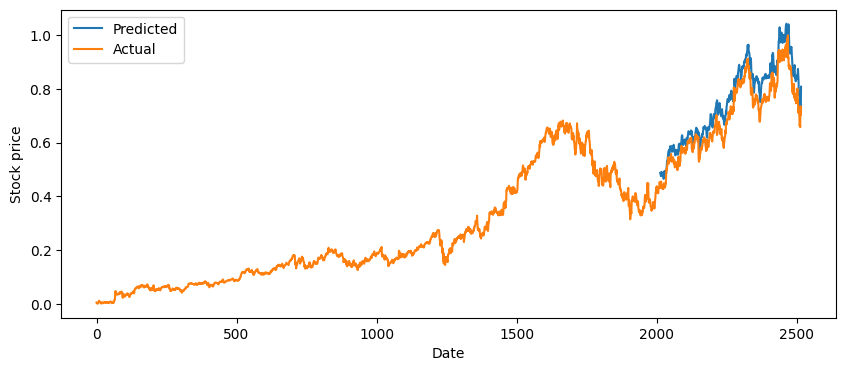

In [214]:
plt.figure(figsize = (10, 4))
plt.plot(range(data.shape[0] - pred.shape[0],data.shape[0]) ,pred.to('cpu'), label = 'Predicted')
plt.plot(range(0, data.shape[0]) ,data[:,-3], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.legend();